## GAN on the Fashion MNIST dataset
### Importing dependencies

In [0]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


### Loading Fashion-MNIST Data

In [0]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


### Summarize loaded dataset and plot first images

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


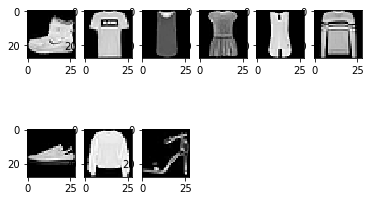

In [0]:
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
# plot images
for i in range(9):
    # define subplot
    plt.subplot(260 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

### Define for model

In [0]:
img_rows = 28
img_cols = 28
channels = 1
latent_dim = 200

img_shape = (img_rows, img_cols, channels)
optimizer = Adam(0.0002, 0.5)

### Build the Discriminator

In [0]:
def build_discriminator(img_shape):

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    #model.add(Dense(512))
    #model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [0]:
discriminator = build_discriminator(img_shape,)
discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

### Build the Generator

In [0]:
def build_generator(img_shape, latent_dim):

    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(2048))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [0]:
generator = build_generator(img_shape, latent_dim)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               51456     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_13 (Dense)             (None, 1024)             

#### The Generator takes noise as input

In [0]:
z = Input(shape=(latent_dim,))
img = generator(z)

#### For the combined model we will only train the generator

In [0]:
discriminator.trainable = False

#### The discriminator takes generated images as input and determines validity

In [0]:
validity = discriminator(img)

#### The combined model  (stacked generator and discriminator)
Trains the generator to fool the discriminator

In [0]:
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

## Train Model

In [0]:
epochs = 3000
batch_size = 32
sample_interval = 200 

Rescale -1 to 1

In [0]:
X_train = trainX / 127.5 - 1.

In [0]:
X_train = np.expand_dims(X_train, axis=3)

Adversarial ground truths

In [0]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

sample plot

In [0]:
def sample_images(epoch, latent_dim, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.670051, acc.: 70.31%] [G loss: 0.668983]


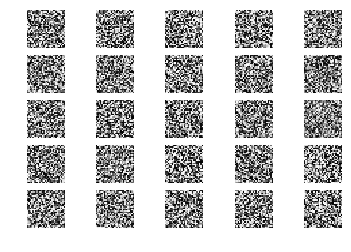

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.459748, acc.: 71.88%] [G loss: 0.700420]
2 [D loss: 0.395092, acc.: 73.44%] [G loss: 0.821463]
3 [D loss: 0.321541, acc.: 84.38%] [G loss: 1.014580]
4 [D loss: 0.255829, acc.: 95.31%] [G loss: 1.181473]
5 [D loss: 0.222993, acc.: 95.31%] [G loss: 1.316990]
6 [D loss: 0.182928, acc.: 96.88%] [G loss: 1.340774]
7 [D loss: 0.171751, acc.: 100.00%] [G loss: 1.528393]
8 [D loss: 0.139018, acc.: 100.00%] [G loss: 1.688570]
9 [D loss: 0.125861, acc.: 100.00%] [G loss: 1.766447]
10 [D loss: 0.102642, acc.: 100.00%] [G loss: 1.958542]
11 [D loss: 0.110051, acc.: 100.00%] [G loss: 1.941413]
12 [D loss: 0.105524, acc.: 100.00%] [G loss: 2.075828]
13 [D loss: 0.104006, acc.: 98.44%] [G loss: 1.961619]
14 [D loss: 0.093693, acc.: 100.00%] [G loss: 2.216588]
15 [D loss: 0.076087, acc.: 100.00%] [G loss: 2.281106]
16 [D loss: 0.063483, acc.: 100.00%] [G loss: 2.315295]
17 [D loss: 0.066672, acc.: 100.00%] [G loss: 2.403511]
18 [D loss: 0.063659, acc.: 100.00%] [G loss: 2.455549]
19 [D lo

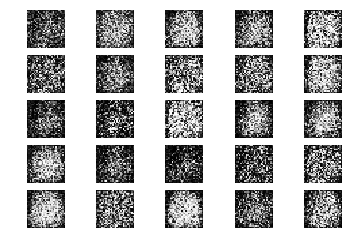

201 [D loss: 0.398453, acc.: 87.50%] [G loss: 2.802798]
202 [D loss: 0.295757, acc.: 84.38%] [G loss: 3.352201]
203 [D loss: 0.218715, acc.: 93.75%] [G loss: 3.387707]
204 [D loss: 0.276071, acc.: 85.94%] [G loss: 2.558325]
205 [D loss: 0.308194, acc.: 85.94%] [G loss: 3.680987]
206 [D loss: 0.452224, acc.: 82.81%] [G loss: 3.259472]
207 [D loss: 0.194110, acc.: 95.31%] [G loss: 3.141404]
208 [D loss: 0.538609, acc.: 67.19%] [G loss: 3.273588]
209 [D loss: 0.276056, acc.: 90.62%] [G loss: 2.577674]
210 [D loss: 0.365130, acc.: 84.38%] [G loss: 3.750780]
211 [D loss: 0.455585, acc.: 82.81%] [G loss: 2.866441]
212 [D loss: 0.407499, acc.: 81.25%] [G loss: 2.550373]
213 [D loss: 0.266946, acc.: 85.94%] [G loss: 3.172536]
214 [D loss: 0.458509, acc.: 82.81%] [G loss: 2.632535]
215 [D loss: 0.198856, acc.: 93.75%] [G loss: 3.011868]
216 [D loss: 0.418918, acc.: 84.38%] [G loss: 2.815779]
217 [D loss: 0.369616, acc.: 85.94%] [G loss: 2.958024]
218 [D loss: 0.517537, acc.: 76.56%] [G loss: 2.

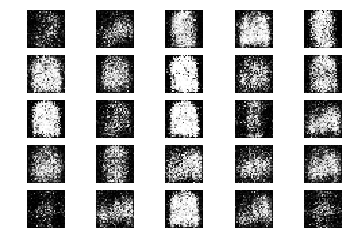

401 [D loss: 0.603076, acc.: 65.62%] [G loss: 0.986063]
402 [D loss: 0.608734, acc.: 59.38%] [G loss: 1.050196]
403 [D loss: 0.571193, acc.: 70.31%] [G loss: 1.057116]
404 [D loss: 0.648864, acc.: 62.50%] [G loss: 0.919062]
405 [D loss: 0.657305, acc.: 56.25%] [G loss: 0.949445]
406 [D loss: 0.678002, acc.: 59.38%] [G loss: 0.912190]
407 [D loss: 0.684567, acc.: 56.25%] [G loss: 0.897065]
408 [D loss: 0.604220, acc.: 70.31%] [G loss: 1.007659]
409 [D loss: 0.572572, acc.: 79.69%] [G loss: 1.005776]
410 [D loss: 0.678532, acc.: 64.06%] [G loss: 0.918864]
411 [D loss: 0.641300, acc.: 70.31%] [G loss: 0.948306]
412 [D loss: 0.705031, acc.: 60.94%] [G loss: 0.986653]
413 [D loss: 0.549405, acc.: 71.88%] [G loss: 1.036932]
414 [D loss: 0.647013, acc.: 65.62%] [G loss: 1.041558]
415 [D loss: 0.592383, acc.: 76.56%] [G loss: 0.994104]
416 [D loss: 0.596524, acc.: 73.44%] [G loss: 1.023974]
417 [D loss: 0.583325, acc.: 73.44%] [G loss: 1.080122]
418 [D loss: 0.654251, acc.: 60.94%] [G loss: 0.

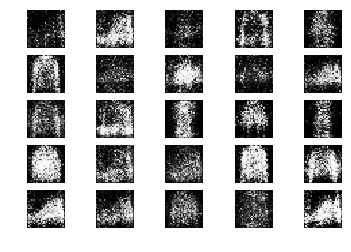

601 [D loss: 0.607532, acc.: 67.19%] [G loss: 0.886271]
602 [D loss: 0.557469, acc.: 75.00%] [G loss: 0.939666]
603 [D loss: 0.613527, acc.: 67.19%] [G loss: 0.970727]
604 [D loss: 0.659815, acc.: 57.81%] [G loss: 1.022450]
605 [D loss: 0.720783, acc.: 59.38%] [G loss: 0.999787]
606 [D loss: 0.615919, acc.: 70.31%] [G loss: 1.024750]
607 [D loss: 0.603712, acc.: 78.12%] [G loss: 0.889741]
608 [D loss: 0.572723, acc.: 65.62%] [G loss: 0.943681]
609 [D loss: 0.578176, acc.: 70.31%] [G loss: 0.982613]
610 [D loss: 0.649462, acc.: 57.81%] [G loss: 0.949672]
611 [D loss: 0.645973, acc.: 62.50%] [G loss: 0.981909]
612 [D loss: 0.568889, acc.: 73.44%] [G loss: 0.994776]
613 [D loss: 0.635862, acc.: 64.06%] [G loss: 0.964658]
614 [D loss: 0.669060, acc.: 59.38%] [G loss: 1.002386]
615 [D loss: 0.660052, acc.: 59.38%] [G loss: 0.980679]
616 [D loss: 0.540419, acc.: 73.44%] [G loss: 1.033418]
617 [D loss: 0.642236, acc.: 59.38%] [G loss: 0.942103]
618 [D loss: 0.535826, acc.: 82.81%] [G loss: 1.

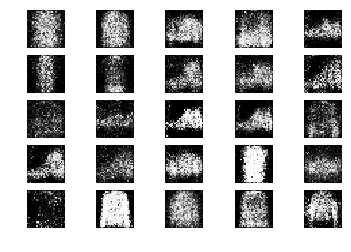

801 [D loss: 0.658928, acc.: 60.94%] [G loss: 0.881534]
802 [D loss: 0.601143, acc.: 75.00%] [G loss: 0.915432]
803 [D loss: 0.591082, acc.: 73.44%] [G loss: 0.899005]
804 [D loss: 0.587225, acc.: 71.88%] [G loss: 0.795364]
805 [D loss: 0.668224, acc.: 64.06%] [G loss: 0.847138]
806 [D loss: 0.587764, acc.: 70.31%] [G loss: 0.947195]
807 [D loss: 0.583470, acc.: 68.75%] [G loss: 0.960603]
808 [D loss: 0.619888, acc.: 68.75%] [G loss: 0.938110]
809 [D loss: 0.580159, acc.: 71.88%] [G loss: 0.995136]
810 [D loss: 0.580683, acc.: 71.88%] [G loss: 0.959952]
811 [D loss: 0.609414, acc.: 57.81%] [G loss: 0.919138]
812 [D loss: 0.531375, acc.: 70.31%] [G loss: 0.959028]
813 [D loss: 0.618380, acc.: 65.62%] [G loss: 0.881441]
814 [D loss: 0.541640, acc.: 71.88%] [G loss: 0.929401]
815 [D loss: 0.629326, acc.: 64.06%] [G loss: 0.941808]
816 [D loss: 0.638773, acc.: 60.94%] [G loss: 0.912265]
817 [D loss: 0.639529, acc.: 65.62%] [G loss: 0.907124]
818 [D loss: 0.645644, acc.: 62.50%] [G loss: 0.

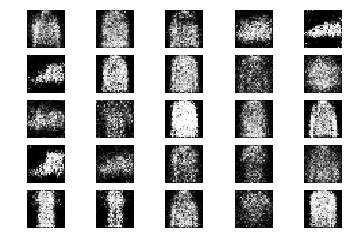

1001 [D loss: 0.601643, acc.: 70.31%] [G loss: 0.872647]
1002 [D loss: 0.657988, acc.: 70.31%] [G loss: 0.868941]
1003 [D loss: 0.591689, acc.: 71.88%] [G loss: 0.904942]
1004 [D loss: 0.594918, acc.: 70.31%] [G loss: 0.887577]
1005 [D loss: 0.573355, acc.: 70.31%] [G loss: 0.894926]
1006 [D loss: 0.632953, acc.: 60.94%] [G loss: 0.977364]
1007 [D loss: 0.679374, acc.: 54.69%] [G loss: 0.863253]
1008 [D loss: 0.551907, acc.: 78.12%] [G loss: 0.922569]
1009 [D loss: 0.576415, acc.: 73.44%] [G loss: 0.974920]
1010 [D loss: 0.625512, acc.: 62.50%] [G loss: 0.987047]
1011 [D loss: 0.628001, acc.: 65.62%] [G loss: 0.865831]
1012 [D loss: 0.730755, acc.: 43.75%] [G loss: 0.916841]
1013 [D loss: 0.600012, acc.: 68.75%] [G loss: 0.864829]
1014 [D loss: 0.621536, acc.: 68.75%] [G loss: 0.930820]
1015 [D loss: 0.585548, acc.: 75.00%] [G loss: 0.935595]
1016 [D loss: 0.612660, acc.: 64.06%] [G loss: 0.924530]
1017 [D loss: 0.591986, acc.: 67.19%] [G loss: 0.891200]
1018 [D loss: 0.604754, acc.: 6

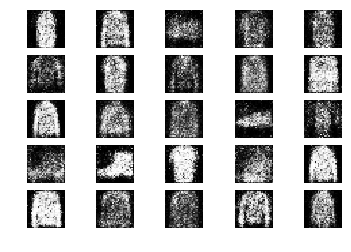

1201 [D loss: 0.661529, acc.: 57.81%] [G loss: 0.813496]
1202 [D loss: 0.580549, acc.: 73.44%] [G loss: 0.867220]
1203 [D loss: 0.596870, acc.: 70.31%] [G loss: 0.811465]
1204 [D loss: 0.589572, acc.: 62.50%] [G loss: 0.834503]
1205 [D loss: 0.674236, acc.: 64.06%] [G loss: 0.937321]
1206 [D loss: 0.567710, acc.: 70.31%] [G loss: 0.848087]
1207 [D loss: 0.665306, acc.: 59.38%] [G loss: 0.804681]
1208 [D loss: 0.606417, acc.: 64.06%] [G loss: 0.867017]
1209 [D loss: 0.639650, acc.: 59.38%] [G loss: 0.949596]
1210 [D loss: 0.603419, acc.: 75.00%] [G loss: 0.839859]
1211 [D loss: 0.587406, acc.: 67.19%] [G loss: 0.895384]
1212 [D loss: 0.541467, acc.: 75.00%] [G loss: 0.815900]
1213 [D loss: 0.607112, acc.: 62.50%] [G loss: 0.928191]
1214 [D loss: 0.724634, acc.: 48.44%] [G loss: 0.854605]
1215 [D loss: 0.635734, acc.: 59.38%] [G loss: 0.865149]
1216 [D loss: 0.641554, acc.: 57.81%] [G loss: 0.946823]
1217 [D loss: 0.631231, acc.: 64.06%] [G loss: 0.862514]
1218 [D loss: 0.622864, acc.: 6

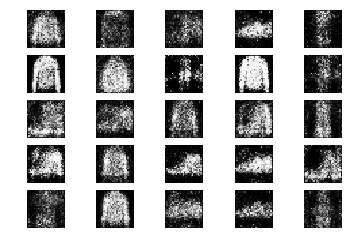

1401 [D loss: 0.564969, acc.: 78.12%] [G loss: 0.873503]
1402 [D loss: 0.637950, acc.: 62.50%] [G loss: 0.932668]
1403 [D loss: 0.610920, acc.: 68.75%] [G loss: 0.949437]
1404 [D loss: 0.669302, acc.: 54.69%] [G loss: 0.812366]
1405 [D loss: 0.626041, acc.: 62.50%] [G loss: 0.875170]
1406 [D loss: 0.600641, acc.: 65.62%] [G loss: 0.877556]
1407 [D loss: 0.577251, acc.: 79.69%] [G loss: 0.922267]
1408 [D loss: 0.595187, acc.: 67.19%] [G loss: 0.882015]
1409 [D loss: 0.667211, acc.: 64.06%] [G loss: 0.862399]
1410 [D loss: 0.580275, acc.: 75.00%] [G loss: 0.832286]
1411 [D loss: 0.684516, acc.: 56.25%] [G loss: 0.865159]
1412 [D loss: 0.589625, acc.: 70.31%] [G loss: 0.811804]
1413 [D loss: 0.609281, acc.: 65.62%] [G loss: 0.794466]
1414 [D loss: 0.666190, acc.: 59.38%] [G loss: 0.782310]
1415 [D loss: 0.595951, acc.: 64.06%] [G loss: 0.873142]
1416 [D loss: 0.637664, acc.: 56.25%] [G loss: 0.892014]
1417 [D loss: 0.635964, acc.: 62.50%] [G loss: 0.942051]
1418 [D loss: 0.566754, acc.: 7

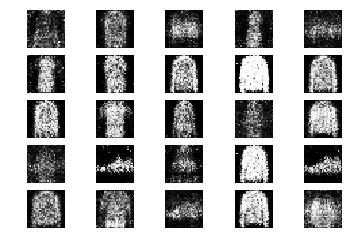

1601 [D loss: 0.666493, acc.: 48.44%] [G loss: 0.864718]
1602 [D loss: 0.635275, acc.: 62.50%] [G loss: 0.957809]
1603 [D loss: 0.615784, acc.: 62.50%] [G loss: 0.963720]
1604 [D loss: 0.619232, acc.: 65.62%] [G loss: 0.937000]
1605 [D loss: 0.596080, acc.: 71.88%] [G loss: 0.974604]
1606 [D loss: 0.634875, acc.: 65.62%] [G loss: 0.926739]
1607 [D loss: 0.767222, acc.: 42.19%] [G loss: 0.921516]
1608 [D loss: 0.605607, acc.: 68.75%] [G loss: 0.853753]
1609 [D loss: 0.579743, acc.: 70.31%] [G loss: 0.976164]
1610 [D loss: 0.605966, acc.: 67.19%] [G loss: 0.956317]
1611 [D loss: 0.624964, acc.: 62.50%] [G loss: 0.898986]
1612 [D loss: 0.617592, acc.: 73.44%] [G loss: 0.925550]
1613 [D loss: 0.577811, acc.: 68.75%] [G loss: 0.931228]
1614 [D loss: 0.603258, acc.: 68.75%] [G loss: 0.861498]
1615 [D loss: 0.592009, acc.: 65.62%] [G loss: 0.921909]
1616 [D loss: 0.604132, acc.: 67.19%] [G loss: 0.939018]
1617 [D loss: 0.586772, acc.: 64.06%] [G loss: 0.919950]
1618 [D loss: 0.606092, acc.: 6

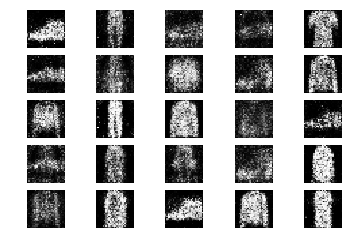

1801 [D loss: 0.640666, acc.: 62.50%] [G loss: 0.967161]
1802 [D loss: 0.665483, acc.: 60.94%] [G loss: 1.082066]
1803 [D loss: 0.623926, acc.: 67.19%] [G loss: 0.963251]
1804 [D loss: 0.659014, acc.: 65.62%] [G loss: 1.002983]
1805 [D loss: 0.616417, acc.: 67.19%] [G loss: 0.940000]
1806 [D loss: 0.630504, acc.: 67.19%] [G loss: 0.959448]
1807 [D loss: 0.591328, acc.: 73.44%] [G loss: 0.887525]
1808 [D loss: 0.607739, acc.: 67.19%] [G loss: 0.888476]
1809 [D loss: 0.641797, acc.: 68.75%] [G loss: 0.885747]
1810 [D loss: 0.576940, acc.: 68.75%] [G loss: 0.863801]
1811 [D loss: 0.674800, acc.: 57.81%] [G loss: 0.873010]
1812 [D loss: 0.662155, acc.: 57.81%] [G loss: 0.869238]
1813 [D loss: 0.577246, acc.: 67.19%] [G loss: 0.938109]
1814 [D loss: 0.637870, acc.: 59.38%] [G loss: 0.960239]
1815 [D loss: 0.633566, acc.: 57.81%] [G loss: 0.995009]
1816 [D loss: 0.556165, acc.: 76.56%] [G loss: 0.943201]
1817 [D loss: 0.649841, acc.: 56.25%] [G loss: 0.942114]
1818 [D loss: 0.604815, acc.: 6

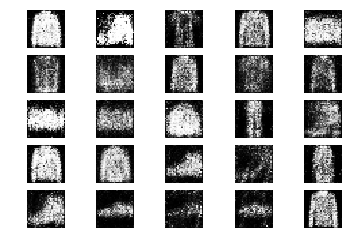

2001 [D loss: 0.610508, acc.: 64.06%] [G loss: 0.950513]
2002 [D loss: 0.643819, acc.: 73.44%] [G loss: 0.796541]
2003 [D loss: 0.598165, acc.: 70.31%] [G loss: 0.847971]
2004 [D loss: 0.681254, acc.: 56.25%] [G loss: 0.850695]
2005 [D loss: 0.659222, acc.: 62.50%] [G loss: 0.822505]
2006 [D loss: 0.564362, acc.: 70.31%] [G loss: 0.898472]
2007 [D loss: 0.605869, acc.: 64.06%] [G loss: 0.930751]
2008 [D loss: 0.619787, acc.: 56.25%] [G loss: 0.932090]
2009 [D loss: 0.627348, acc.: 67.19%] [G loss: 0.994223]
2010 [D loss: 0.613734, acc.: 64.06%] [G loss: 0.946609]
2011 [D loss: 0.590522, acc.: 70.31%] [G loss: 0.963472]
2012 [D loss: 0.566181, acc.: 71.88%] [G loss: 0.926644]
2013 [D loss: 0.679795, acc.: 65.62%] [G loss: 0.966019]
2014 [D loss: 0.594996, acc.: 68.75%] [G loss: 0.982100]
2015 [D loss: 0.622930, acc.: 68.75%] [G loss: 0.952137]
2016 [D loss: 0.626984, acc.: 67.19%] [G loss: 0.901669]
2017 [D loss: 0.570169, acc.: 73.44%] [G loss: 0.905769]
2018 [D loss: 0.646760, acc.: 5

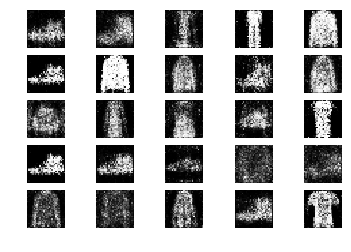

2201 [D loss: 0.596749, acc.: 67.19%] [G loss: 1.044894]
2202 [D loss: 0.699992, acc.: 65.62%] [G loss: 0.998812]
2203 [D loss: 0.647210, acc.: 60.94%] [G loss: 0.946404]
2204 [D loss: 0.612545, acc.: 68.75%] [G loss: 0.995327]
2205 [D loss: 0.669365, acc.: 62.50%] [G loss: 1.018474]
2206 [D loss: 0.631975, acc.: 65.62%] [G loss: 0.960806]
2207 [D loss: 0.619679, acc.: 65.62%] [G loss: 0.934988]
2208 [D loss: 0.603855, acc.: 57.81%] [G loss: 1.091526]
2209 [D loss: 0.660700, acc.: 59.38%] [G loss: 0.945331]
2210 [D loss: 0.596942, acc.: 68.75%] [G loss: 0.972857]
2211 [D loss: 0.637093, acc.: 65.62%] [G loss: 0.910413]
2212 [D loss: 0.657755, acc.: 59.38%] [G loss: 0.914560]
2213 [D loss: 0.621901, acc.: 67.19%] [G loss: 0.943393]
2214 [D loss: 0.635389, acc.: 65.62%] [G loss: 0.965279]
2215 [D loss: 0.583259, acc.: 73.44%] [G loss: 0.957770]
2216 [D loss: 0.589923, acc.: 62.50%] [G loss: 0.902111]
2217 [D loss: 0.649187, acc.: 62.50%] [G loss: 0.884601]
2218 [D loss: 0.652701, acc.: 5

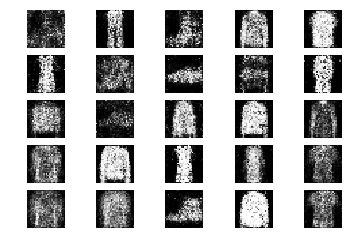

2401 [D loss: 0.653901, acc.: 59.38%] [G loss: 0.919380]
2402 [D loss: 0.574183, acc.: 73.44%] [G loss: 1.061987]
2403 [D loss: 0.636278, acc.: 64.06%] [G loss: 0.954604]
2404 [D loss: 0.637779, acc.: 64.06%] [G loss: 0.931669]
2405 [D loss: 0.670838, acc.: 56.25%] [G loss: 0.927546]
2406 [D loss: 0.564041, acc.: 71.88%] [G loss: 1.040588]
2407 [D loss: 0.560269, acc.: 68.75%] [G loss: 1.005290]
2408 [D loss: 0.688599, acc.: 53.12%] [G loss: 0.950939]
2409 [D loss: 0.575753, acc.: 64.06%] [G loss: 0.931899]
2410 [D loss: 0.641934, acc.: 60.94%] [G loss: 0.964693]
2411 [D loss: 0.615918, acc.: 70.31%] [G loss: 0.795987]
2412 [D loss: 0.655221, acc.: 57.81%] [G loss: 0.947552]
2413 [D loss: 0.546481, acc.: 73.44%] [G loss: 0.898779]
2414 [D loss: 0.585714, acc.: 65.62%] [G loss: 0.933562]
2415 [D loss: 0.687506, acc.: 60.94%] [G loss: 0.834303]
2416 [D loss: 0.567991, acc.: 78.12%] [G loss: 1.005383]
2417 [D loss: 0.685932, acc.: 53.12%] [G loss: 1.097844]
2418 [D loss: 0.613274, acc.: 6

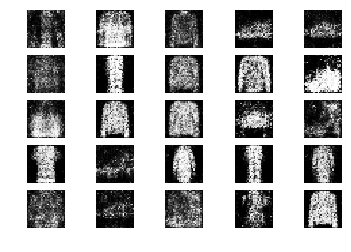

2601 [D loss: 0.573305, acc.: 73.44%] [G loss: 1.061702]
2602 [D loss: 0.574768, acc.: 68.75%] [G loss: 0.998065]
2603 [D loss: 0.631582, acc.: 64.06%] [G loss: 0.877018]
2604 [D loss: 0.679905, acc.: 60.94%] [G loss: 0.842876]
2605 [D loss: 0.617266, acc.: 67.19%] [G loss: 0.941882]
2606 [D loss: 0.599032, acc.: 62.50%] [G loss: 0.850271]
2607 [D loss: 0.608079, acc.: 71.88%] [G loss: 0.939603]
2608 [D loss: 0.654865, acc.: 68.75%] [G loss: 0.936666]
2609 [D loss: 0.633914, acc.: 64.06%] [G loss: 0.907447]
2610 [D loss: 0.644698, acc.: 54.69%] [G loss: 0.972317]
2611 [D loss: 0.684852, acc.: 50.00%] [G loss: 0.922363]
2612 [D loss: 0.604022, acc.: 70.31%] [G loss: 0.961091]
2613 [D loss: 0.563119, acc.: 73.44%] [G loss: 0.924304]
2614 [D loss: 0.560106, acc.: 75.00%] [G loss: 1.005159]
2615 [D loss: 0.608130, acc.: 68.75%] [G loss: 0.990040]
2616 [D loss: 0.659555, acc.: 60.94%] [G loss: 0.889787]
2617 [D loss: 0.586237, acc.: 67.19%] [G loss: 0.868847]
2618 [D loss: 0.681263, acc.: 6

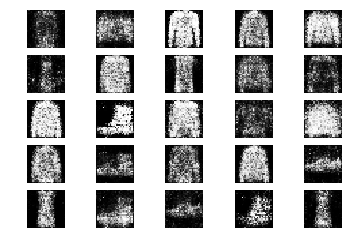

2801 [D loss: 0.506609, acc.: 76.56%] [G loss: 1.065364]
2802 [D loss: 0.603007, acc.: 65.62%] [G loss: 0.904143]
2803 [D loss: 0.622413, acc.: 65.62%] [G loss: 1.012617]
2804 [D loss: 0.621127, acc.: 70.31%] [G loss: 0.930916]
2805 [D loss: 0.588970, acc.: 70.31%] [G loss: 0.983978]
2806 [D loss: 0.575587, acc.: 70.31%] [G loss: 0.935129]
2807 [D loss: 0.645473, acc.: 56.25%] [G loss: 1.034759]
2808 [D loss: 0.618771, acc.: 64.06%] [G loss: 1.053720]
2809 [D loss: 0.624583, acc.: 65.62%] [G loss: 0.945197]
2810 [D loss: 0.660677, acc.: 64.06%] [G loss: 0.854421]
2811 [D loss: 0.648797, acc.: 60.94%] [G loss: 0.891070]
2812 [D loss: 0.598590, acc.: 70.31%] [G loss: 0.903681]
2813 [D loss: 0.632048, acc.: 60.94%] [G loss: 0.930486]
2814 [D loss: 0.600082, acc.: 71.88%] [G loss: 0.898088]
2815 [D loss: 0.637168, acc.: 60.94%] [G loss: 0.979544]
2816 [D loss: 0.548798, acc.: 79.69%] [G loss: 0.933103]
2817 [D loss: 0.578700, acc.: 67.19%] [G loss: 0.896337]
2818 [D loss: 0.661044, acc.: 5

In [0]:
for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate a batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Train the generator (to have the discriminator label samples as valid)
    g_loss = combined.train_on_batch(noise, valid)

    # Plot the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # If at save interval => save generated image samples
    if epoch % sample_interval == 0:
        sample_images(epoch, latent_dim, generator)

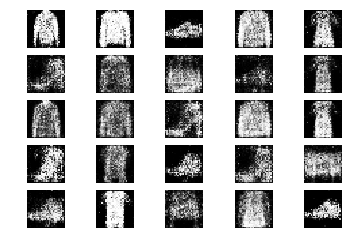

In [0]:
sample_images(epoch, latent_dim, generator)